# **Food/Fruit Recognition and Calorie Estimation**
## **Part E Multi Segmentation**

## **Importing Libraries**

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import json
import time
from datetime import timedelta
from scipy import stats
from skimage import measure


# **Configuration**

In [ ]:
class MultiClassConfig:
    # Paths
    PROJECT_DATA_PATH = '/kaggle/input/vision-data/Project Data'
    FRUIT_PATH = os.path.join(PROJECT_DATA_PATH, 'Fruit')
    FRUIT_TRAIN_PATH = os.path.join(FRUIT_PATH, 'Train')
    FRUIT_VAL_PATH = os.path.join(FRUIT_PATH, 'Validation')

    # Model Configuration
    IMG_SIZE = 224
    BATCH_SIZE = 8

    # Training Phases
    EPOCHS_HEAD = 15
    EPOCHS_FINE_TUNE = 25

    LR_HEAD = 1e-4
    LR_FINE_TUNE = 5e-6

    NUM_CLASSES = 31


    OUTPUT_DIR = 'multiclass_segmentation_outputs'
    MODEL_DIR = os.path.join(OUTPUT_DIR, 'models')
    PLOTS_DIR = os.path.join(OUTPUT_DIR, 'plots')
    LOGS_DIR = os.path.join(OUTPUT_DIR, 'logs')


    CLASS_MAPPING_FILE = os.path.join(OUTPUT_DIR, 'class_mapping.json')
    COLOR_MAPPING_FILE = os.path.join(OUTPUT_DIR, 'color_mapping.json')
    BEST_MODEL_PATH = os.path.join(MODEL_DIR, 'best_multiclass_resnet50_unet.keras')


for directory in [MultiClassConfig.OUTPUT_DIR, MultiClassConfig.MODEL_DIR,
                  MultiClassConfig.PLOTS_DIR, MultiClassConfig.LOGS_DIR]:
    os.makedirs(directory, exist_ok=True)

print("=" * 80)
print("🎨 ADVANCED FRUIT SEGMENTATION: U-Net with ResNet50V2 + Realistic Colors")
print("=" * 80)


🎨 ADVANCED FRUIT SEGMENTATION: U-Net with ResNet50V2 + Realistic Colors


# REALISTIC COLOR MAPPING FOR FRUITS

In [ ]:

def create_realistic_color_mapping():
    """
    Creates realistic RGB colors for each fruit category
    """
    color_map = {
        'background': [0, 0, 0],

        # Apples - Red/Golden tones
        'Apple_Gala': [220, 20, 60],  # Crimson red
        'Apple_Golden Delicious': [255, 215, 0],  # Golden

        # Green fruits
        'Avocado': [107, 142, 35],  # Olive green
        'Guava': [189, 252, 201],  # Light green
        'Kiwi': [141, 182, 0],  # Kiwi green
        'Green Coconut': [245, 245, 220],  # Beige white

        # Yellow/Orange fruits
        'Banana': [255, 225, 53],  # Bright yellow
        'Orange': [255, 140, 0],  # Orange
        'Malta': [255, 165, 79],  # Light orange
        'Mango Golden Queen': [255, 200, 50],  # Golden mango
        'Mango_Alphonso': [255, 179, 71],  # Mango yellow
        'Mango_Amrapali': [255, 193, 37],  # Yellow mango
        'Mango_Bari': [255, 160, 122],  # Light salmon
        'Mango_Himsagar': [255, 185, 15],  # Deep yellow
        'Carambola': [255, 250, 160],  # Star fruit yellow
        'Persimmon': [255, 99, 71],  # Tomato orange

        # Red/Purple fruits
        'Berry': [139, 0, 139],  # Dark magenta
        'Grape': [128, 0, 128],  # Purple
        'Burmese Grape': [218, 112, 214],  # Orchid
        'Pomegranate': [192, 57, 43],  # Deep red
        'Dragon': [255, 20, 147],  # Deep pink
        'Watermelon': [252, 92, 101],  # Watermelon red
        'Lichi': [255, 182, 193],  # Light pink

        # Brown fruits
        'Date Palm': [139, 69, 19],  # Saddle brown
        'Elephant Apple': [188, 143, 143],  # Rosy brown
        'Hog Plum': [218, 165, 32],  # Golden rod

        # Other
        'Olive': [128, 128, 0],  # Olive
        'Palm': [210, 105, 30],  # Chocolate
        'Pineapple': [255, 215, 0],  # Gold
        'White Pear': [245, 245, 220],  # Beige
    }

    # Save color mapping
    with open(MultiClassConfig.COLOR_MAPPING_FILE, 'w') as f:
        json.dump(color_map, f, indent=4)

    return color_map

# DATA LOADING

In [ ]:
def build_class_mapping(root_dir):
    if not os.path.exists(root_dir):
        print(f"⚠️ Path does not exist: {root_dir}")
        return {}

    categories = sorted([d for d in os.listdir(root_dir)
                           if os.path.isdir(os.path.join(root_dir, d))])

    class_mapping = {'background': 0}
    for idx, category in enumerate(categories, start=1):
        class_mapping[category] = idx

    print(f"📊 Found {len(categories)} fruit categories")
    print(f"📋 Total classes: {len(class_mapping)}")

    with open(MultiClassConfig.CLASS_MAPPING_FILE, 'w') as f:
        json.dump(class_mapping, f, indent=4)

    return class_mapping

def load_multiclass_segmentation_data(root_dir, class_mapping, verbose=True):

    img_paths = []
    mask_paths_list = []
    category_labels = []

    categories = sorted([d for d in os.listdir(root_dir)
                           if os.path.isdir(os.path.join(root_dir, d))])

    pbar = tqdm(categories, desc="Loading data", disable=not verbose)

    for category in pbar:
        if category not in class_mapping:
            continue

        class_idx = class_mapping[category]
        category_path = os.path.join(root_dir, category)
        images_path = os.path.join(category_path, 'Images')

        masks_path = os.path.join(category_path, 'Masks')
        if not os.path.exists(masks_path):
            masks_path = os.path.join(category_path, 'Mask')

        if not os.path.exists(images_path) or not os.path.exists(masks_path):
            continue

        try:
            image_files = sorted([f for f in os.listdir(images_path)
                                if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])

            for img_file in image_files:
                img_path = os.path.join(images_path, img_file)
                base_name = os.path.splitext(img_file)[0]
                mask_found = None

                candidate_names = [
                    base_name + '.png', base_name + '_mask.png',
                    base_name + '.jpg', base_name + '_mask.jpg',
                    base_name + '_mask.jpeg', base_name + '.bmp'
                ]

                for candidate in candidate_names:
                    mask_candidate = os.path.join(masks_path, candidate)
                    if os.path.exists(mask_candidate):
                        mask_found = mask_candidate
                        break

                if mask_found and os.path.exists(img_path):
                    img_paths.append(img_path)
                    mask_paths_list.append(mask_found)
                    category_labels.append(class_idx)

        except Exception as e:
            print(f"\n⚠️ Error processing category {category}: {e}")

    pbar.close()
    return img_paths, mask_paths_list, category_labels

# PREPROCESSING & AUGMENTATION

In [ ]:
def preprocess_image_base(img_path, mask_path, class_label, img_size=224):
    # Load Image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, (img_size, img_size))
    img = preprocess_input(img)

    # Load Mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_image(mask, channels=1, expand_animations=False)
    mask.set_shape([None, None, 1])
    mask = tf.image.resize(mask, (img_size, img_size), method='nearest')

    # Create Class Mask (support for multi-class in single mask)
    mask_binary = tf.cast(mask > 128, tf.float32)
    mask_class = mask_binary * tf.cast(class_label, tf.float32)
    mask_class = tf.cast(mask_class, tf.int32)

    return img, mask_class

def augment_data(img, mask):
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)

    # Random rotation (90, 180, 270 degrees)
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k=k)
    mask = tf.image.rot90(mask, k=k)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)

    return img, mask

def preprocess_train(x, y, z):
    img, mask = preprocess_image_base(x, y, z, MultiClassConfig.IMG_SIZE)
    img, mask = augment_data(img, mask)
    return img, mask

def preprocess_val(x, y, z):
    img, mask = preprocess_image_base(x, y, z, MultiClassConfig.IMG_SIZE)
    return img, mask

def create_dataset(img_paths, mask_paths, labels, is_train=True):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths, labels))

    if is_train:
        ds = ds.shuffle(buffer_size=len(img_paths))
        ds = ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(MultiClassConfig.BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


# MODEL ARCHITECTURE (ResNet50V2_UNet)

In [ ]:

def build_pretrained_unet(num_classes):
    input_shape = (MultiClassConfig.IMG_SIZE, MultiClassConfig.IMG_SIZE, 3)

    # Pre-trained encoder
    base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    # Skip connections
    bridge = base_model.output
    s4 = base_model.get_layer("conv4_block6_1_relu").output
    s3 = base_model.get_layer("conv3_block4_1_relu").output
    s2 = base_model.get_layer("conv2_block3_1_relu").output
    s1 = base_model.get_layer("conv1_conv").output

    # Enhanced Decoder with Attention-like mechanism

    # Block 1
    d1 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(bridge)
    d1 = layers.Concatenate()([d1, s4])
    d1 = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(d1)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(d1)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.Dropout(0.3)(d1)

    # Block 2
    d2 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(d1)
    d2 = layers.Concatenate()([d2, s3])
    d2 = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(d2)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(d2)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.Dropout(0.3)(d2)

    # Block 3
    d3 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(d2)
    d3 = layers.Concatenate()([d3, s2])
    d3 = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(d3)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(d3)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.Dropout(0.2)(d3)

    # Block 4
    d4 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(d3)
    d4 = layers.Concatenate()([d4, s1])
    d4 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(d4)
    d4 = layers.BatchNormalization()(d4)
    d4 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(d4)
    d4 = layers.BatchNormalization()(d4)

    # Final upsampling
    d5 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(d4)
    d5 = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(d5)
    d5 = layers.BatchNormalization()(d5)
    d5 = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(d5)
    d5 = layers.BatchNormalization()(d5)

    # Output
    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax", dtype='float32')(d5)

    return Model(base_model.input, outputs, name="Enhanced_ResNet50V2_UNet")


# LOSS & METRICS

In [ ]:
def dice_loss(y_true, y_pred):
    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.cast(y_true, tf.int32)
    y_true_one_hot = tf.one_hot(y_true, depth=MultiClassConfig.NUM_CLASSES)

    numerator = 2.0 * tf.reduce_sum(y_true_one_hot * y_pred, axis=[0, 1, 2])
    denominator = tf.reduce_sum(y_true_one_hot + y_pred, axis=[0, 1, 2])
    dice_score = (numerator + 1e-7) / (denominator + 1e-7)

    return 1.0 - tf.reduce_mean(dice_score)

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """
    Focal loss to handle class imbalance
    """

    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.cast(y_true, tf.int32)

    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    pred_prob = tf.reduce_max(y_pred, axis=-1)


    y_pred_classes = tf.cast(tf.argmax(y_pred, axis=-1), tf.int32)

    p_t = tf.where(tf.equal(y_true, y_pred_classes), pred_prob, 1.0 - pred_prob)

    focal_weight = alpha * tf.pow((1.0 - p_t), gamma)
    focal_ce = focal_weight * ce

    return tf.reduce_mean(focal_ce)

def combined_loss(y_true, y_pred):
    ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    ce_loss = tf.reduce_mean(ce_loss)
    d_loss = dice_loss(y_true, y_pred)
    f_loss = focal_loss(y_true, y_pred)

    # Balanced combination
    return (0.4 * ce_loss) + (0.3 * d_loss) + (0.3 * f_loss)

class MultiClassDiceCoefficient(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='dice_coefficient', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.total_dice = self.add_weight(name='total_dice', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.squeeze(y_true, axis=-1)
        y_pred = tf.cast(y_pred, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        dice_sum = 0.0
        valid_classes = 0.0

        for i in range(self.num_classes):
            class_idx = tf.cast(i, tf.float32)
            y_t = tf.cast(tf.equal(y_true, class_idx), tf.float32)
            y_p = tf.cast(tf.equal(y_pred, class_idx), tf.float32)

            inter = tf.reduce_sum(y_t * y_p)
            union = tf.reduce_sum(y_t) + tf.reduce_sum(y_p)
            present = tf.cast(tf.reduce_sum(y_t) > 0, tf.float32)

            dice = tf.math.divide_no_nan(2.0 * inter, union)
            dice_sum += dice * present
            valid_classes += present

        batch_dice = tf.math.divide_no_nan(dice_sum, valid_classes)
        self.total_dice.assign_add(batch_dice)
        self.count.assign_add(1.0)

    def result(self):
        return tf.math.divide_no_nan(self.total_dice, self.count)

    def reset_state(self):
        self.total_dice.assign(0.0)
        self.count.assign(0.0)

# TRAINING WORKFLOW

In [ ]:
def train_system():

    color_mapping = create_realistic_color_mapping()


    class_mapping = build_class_mapping(MultiClassConfig.FRUIT_TRAIN_PATH)
    if not class_mapping:
        return None, None, None

    train_imgs, train_masks, train_lbls = load_multiclass_segmentation_data(
        MultiClassConfig.FRUIT_TRAIN_PATH, class_mapping)
    val_imgs, val_masks, val_lbls = load_multiclass_segmentation_data(
        MultiClassConfig.FRUIT_VAL_PATH, class_mapping)

    if not train_imgs:
        return None, None, None

    print(f"\n✅ Training samples: {len(train_imgs)}")
    print(f"✅ Validation samples: {len(val_imgs)}")


    train_ds = create_dataset(train_imgs, train_masks, train_lbls, is_train=True)
    val_ds = create_dataset(val_imgs, val_masks, val_lbls, is_train=False)


    model = build_pretrained_unet(MultiClassConfig.NUM_CLASSES)


    total_training_start = time.time()

    # -----------------------------------------------------------
    # PHASE 1: Train Decoder
    # -----------------------------------------------------------
    print("\n" + "="*60)
    print("🚀 PHASE 1: Training Decoder (Encoder Frozen)")
    print("="*60)

    phase1_start = time.time()

    model.compile(
        optimizer=optimizers.Adam(learning_rate=MultiClassConfig.LR_HEAD),
        loss=combined_loss,
        metrics=['accuracy', MultiClassDiceCoefficient(MultiClassConfig.NUM_CLASSES)]
    )

    cb_phase1 = [
        ModelCheckpoint(
            MultiClassConfig.BEST_MODEL_PATH,
            save_best_only=True,
            monitor='val_dice_coefficient',
            mode='max',
            verbose=1
        ),
        CSVLogger(os.path.join(MultiClassConfig.LOGS_DIR, 'log_phase1.csv'))
    ]

    history1 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=MultiClassConfig.EPOCHS_HEAD,
        callbacks=cb_phase1,
        verbose=1
    )

    phase1_end = time.time()
    phase1_time = phase1_end - phase1_start

    print(f"\n⏱️ Phase 1 Training Time: {timedelta(seconds=int(phase1_time))} ({phase1_time:.2f} seconds)")

    # -----------------------------------------------------------
    # PHASE 2: Fine-Tuning
    # -----------------------------------------------------------
    print("\n" + "="*60)
    print("🔓 PHASE 2: Fine-Tuning (Unfreezing Encoder)")
    print("="*60)

    phase2_start = time.time()

    model.load_weights(MultiClassConfig.BEST_MODEL_PATH)
    model.trainable = True

    # Keep BatchNorm frozen
    for layer in model.layers:
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = False

    print("✅ Encoder unfrozen. Starting fine-tuning...")

    model.compile(
        optimizer=optimizers.Adam(learning_rate=MultiClassConfig.LR_FINE_TUNE),
        loss=combined_loss,
        metrics=['accuracy', MultiClassDiceCoefficient(MultiClassConfig.NUM_CLASSES)]
    )

    cb_phase2 = [
        EarlyStopping(
            monitor='val_dice_coefficient',
            patience=7,
            restore_best_weights=True,
            mode='max',
            verbose=1
        ),
        ModelCheckpoint(
            MultiClassConfig.BEST_MODEL_PATH,
            save_best_only=True,
            monitor='val_dice_coefficient',
            mode='max',
            verbose=1
        ),
        CSVLogger(os.path.join(MultiClassConfig.LOGS_DIR, 'log_phase2.csv'), append=True)
    ]

    history2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=MultiClassConfig.EPOCHS_HEAD + MultiClassConfig.EPOCHS_FINE_TUNE,
        initial_epoch=MultiClassConfig.EPOCHS_HEAD,
        callbacks=cb_phase2,
        verbose=1
    )

    phase2_end = time.time()
    phase2_time = phase2_end - phase2_start

    total_training_end = time.time()
    total_training_time = total_training_end - total_training_start

    print("\n" + "="*60)
    print("✅ Training Complete!")
    print("="*60)
    print(f"\n⏱️ TRAINING TIME SUMMARY:")
    print("-" * 60)
    print(f"  Phase 1 (Head Training):    {timedelta(seconds=int(phase1_time))} ({phase1_time:.2f}s)")
    print(f"  Phase 2 (Fine-tuning):      {timedelta(seconds=int(phase2_time))} ({phase2_time:.2f}s)")
    print(f"  Total Training Time:        {timedelta(seconds=int(total_training_time))} ({total_training_time:.2f}s)")
    print("-" * 60)

    training_times = {
        'phase1_seconds': phase1_time,
        'phase2_seconds': phase2_time,
        'total_training_seconds': total_training_time,
        'phase1_formatted': str(timedelta(seconds=int(phase1_time))),
        'phase2_formatted': str(timedelta(seconds=int(phase2_time))),
        'total_training_formatted': str(timedelta(seconds=int(total_training_time)))
    }

    with open(os.path.join(MultiClassConfig.OUTPUT_DIR, 'training_times.json'), 'w') as f:
        json.dump(training_times, f, indent=4)

    print(f"\n💾 Training times saved to: {os.path.join(MultiClassConfig.OUTPUT_DIR, 'training_times.json')}")

    return model, class_mapping, color_mapping


print("\n🎯 Starting Advanced Fruit Segmentation System\n")

print("📚 Step 1: Training Model...")
model, class_mapping, color_mapping = train_system()


🎯 Starting Advanced Fruit Segmentation System

📚 Step 1: Training Model...
📊 Found 30 fruit categories
📋 Total classes: 31


Loading data: 100%|██████████| 30/30 [00:00<00:00, 70.88it/s]
I0000 00:00:1766017988.399707      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



✅ Training samples: 1759
✅ Validation samples: 150
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

🚀 PHASE 1: Training Decoder (Encoder Frozen)
Epoch 1/15


I0000 00:00:1766018008.489317     109 service.cc:148] XLA service 0x7d5dec003180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766018008.490163     109 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1766018009.990516     109 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1766018009.997500     109 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits_1/assert_equal_1/Assert/Assert
I0000 00:00:1766018010.972421     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/220 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - accuracy: 0.0211 - dice_coefficient: 0.0409 - loss: 1.8912   

I0000 00:00:1766018028.747123     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3574 - dice_coefficient: 0.1197 - loss: 1.4798

W0000 00:00:1766018045.989130     107 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1766018045.993061     107 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits_1/assert_equal_1/Assert/Assert


220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.3582 - dice_coefficient: 0.1199 - loss: 1.4787

W0000 00:00:1766018066.231325     109 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1766018066.235214     109 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits_1/assert_equal_1/Assert/Assert
W0000 00:00:1766018073.044002     106 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1766018073.045865     106 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits_1/assert_equal_1/Assert/Assert



Epoch 1: val_dice_coefficient improved from -inf to 0.33730, saving model to multiclass_segmentation_outputs/models/best_multiclass_resnet50_unet.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 86s 236ms/step - accuracy: 0.3590 - dice_coefficient: 0.1201 - loss: 1.4777 - val_accuracy: 0.6422 - val_dice_coefficient: 0.3373 - val_loss: 0.9958
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6966 - dice_coefficient: 0.2560 - loss: 0.9471
Epoch 2: val_dice_coefficient improved from 0.33730 to 0.44929, saving model to multiclass_segmentation_outputs/models/best_multiclass_resnet50_unet.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.6967 - dice_coefficient: 0.2561 - loss: 0.9469 - val_accuracy: 0.7075 - val_dice_coefficient: 0.4493 - val_loss: 0.8146
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7377 - dice_coefficient: 0.3412 - loss: 0.8051
Epoch 3: val_dice_coefficient improved from 0.44929 to 0.49828, saving model to multiclass_segmentation_outpu

W0000 00:00:1766018371.886383     107 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1766018371.892582     107 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits_1/assert_equal_1/Assert/Assert


219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9700 - dice_coefficient: 0.9468 - loss: 0.3051

W0000 00:00:1766018399.516679     107 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1766018399.520781     107 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits_1/assert_equal_1/Assert/Assert


220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9700 - dice_coefficient: 0.9468 - loss: 0.3051

W0000 00:00:1766018412.927848     108 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1766018412.931397     108 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits_1/assert_equal_1/Assert/Assert
W0000 00:00:1766018418.481516     108 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1766018418.483333     108 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SparseSoftmaxCrossEntropyWithLogits_1/assert_equal_1/Assert/Assert



Epoch 16: val_dice_coefficient improved from -inf to 0.94105, saving model to multiclass_segmentation_outputs/models/best_multiclass_resnet50_unet.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 65s 191ms/step - accuracy: 0.9700 - dice_coefficient: 0.9469 - loss: 0.3050 - val_accuracy: 0.9564 - val_dice_coefficient: 0.9410 - val_loss: 0.3597
Epoch 17/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9761 - dice_coefficient: 0.9624 - loss: 0.2839
Epoch 17: val_dice_coefficient improved from 0.94105 to 0.94663, saving model to multiclass_segmentation_outputs/models/best_multiclass_resnet50_unet.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.9761 - dice_coefficient: 0.9624 - loss: 0.2839 - val_accuracy: 0.9594 - val_dice_coefficient: 0.9466 - val_loss: 0.3497
Epoch 18/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9781 - dice_coefficient: 0.9667 - loss: 0.2747
Epoch 18: val_dice_coefficient improved from 0.94663 to 0.94886, saving model to multiclass_segmentation_

# POST-PROCESSING & INFERENCE

In [ ]:
def clean_mask_advanced(pred_mask):
    """
    Advanced post-processing with morphological operations
    """

    binary_mask = (pred_mask > 0).astype(np.uint8)


    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)


    labels = measure.label(binary_mask)
    cleaned_mask = pred_mask.copy()

    for region in measure.regionprops(labels):

        if region.area < 500:
            coords = region.coords
            cleaned_mask[coords[:, 0], coords[:, 1]] = 0
            continue


        coords = region.coords
        region_vals = pred_mask[coords[:, 0], coords[:, 1]]
        region_vals = region_vals[region_vals > 0]  # Exclude background

        if len(region_vals) > 0:
            mode_result = stats.mode(region_vals, keepdims=True)
            most_frequent_class = mode_result[0][0]
            cleaned_mask[coords[:, 0], coords[:, 1]] = most_frequent_class

    return cleaned_mask

def get_fruit_color(fruit_name, color_mapping):
    """
    Get RGB color for a fruit
    """
    if fruit_name in color_mapping:
        return np.array(color_mapping[fruit_name], dtype=np.uint8)
    else:

        return np.random.randint(50, 255, size=3, dtype=np.uint8)

def predict_and_visualize(image_path, model=None, class_mapping=None, color_mapping=None):
    """
    Enhanced prediction with realistic colors, multiple fruits support, CONFIDENCE SCORES, and TIMING.
    """

    if model is None or class_mapping is None or color_mapping is None:
        custom_objects = {
            'combined_loss': combined_loss,
            'MultiClassDiceCoefficient': MultiClassDiceCoefficient,
            'dice_loss': dice_loss,
            'focal_loss': focal_loss
        }
        model = tf.keras.models.load_model(
            MultiClassConfig.BEST_MODEL_PATH,
            custom_objects=custom_objects
        )

        with open(MultiClassConfig.CLASS_MAPPING_FILE, 'r') as f:
            class_mapping = json.load(f)

        with open(MultiClassConfig.COLOR_MAPPING_FILE, 'r') as f:
            color_mapping = json.load(f)

    if not os.path.exists(image_path):
        print("❌ Image file not found!")
        return


    reverse_mapping = {v: k for k, v in class_mapping.items()}


    original_img = cv2.imread(image_path)
    if original_img is None:
        print("❌ Invalid image!")
        return

    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    original_height, original_width = original_img.shape[:2]


    img = tf.convert_to_tensor(original_img)
    img = tf.image.resize(img, (MultiClassConfig.IMG_SIZE, MultiClassConfig.IMG_SIZE))
    img_input = preprocess_input(img)
    img_input = tf.expand_dims(img_input, axis=0)

    # =========================================================
    # START: TTA + TIMING ⏱️
    # =========================================================
    print("🔮 Predicting with TTA (Original + H-Flip + V-Flip)...")


    inference_start = time.time()


    img_tensor = tf.convert_to_tensor(img_input)
    img_h_flip = tf.image.flip_left_right(img_tensor)
    img_v_flip = tf.image.flip_up_down(img_tensor)

    batch_input = tf.concat([img_tensor, img_h_flip, img_v_flip], axis=0)


    batch_preds = model.predict(batch_input, verbose=0)


    pred_original = batch_preds[0]
    pred_h_flip_raw = batch_preds[1]
    pred_v_flip_raw = batch_preds[2]


    pred_h_restored = np.fliplr(pred_h_flip_raw)
    pred_v_restored = np.flipud(pred_v_flip_raw)


    avg_preds = (pred_original + pred_h_restored + pred_v_restored) / 3.0


    inference_end = time.time()
    inference_time_ms = (inference_end - inference_start) * 1000  # Convert to milliseconds


    confidence_threshold = 0.50
    max_probs = np.max(avg_preds, axis=-1)
    pred_mask_raw = np.argmax(avg_preds, axis=-1)
    pred_mask_raw[max_probs < confidence_threshold] = 0

    # =========================================================
    # END: TTA + TIMING
    # =========================================================

    print(f"⏱️ Inference Time: {inference_time_ms:.2f} ms") # Print time


    pred_mask = clean_mask_advanced(pred_mask_raw)


    detected_classes = np.unique(pred_mask)
    detected_classes = detected_classes[detected_classes != 0]

    detected_fruits = [reverse_mapping.get(int(cls), f'Unknown_{cls}')
                       for cls in detected_classes]

    print(f"\n🍎 Detected Fruits: {', '.join(detected_fruits) if detected_fruits else 'None (Background only)'}")


    if len(detected_classes) > 0:
        print("\n📊 Confidence Report:")
        print("-" * 60)
        print(f"{'Fruit Name':<25} | {'Mean Probability':<18} | {'Max Probability':<15}")
        print("-" * 60)

        for cls_idx in detected_classes:
            cls_idx = int(cls_idx)
            fruit_name = reverse_mapping.get(cls_idx, f'Unknown_{cls_idx}')

            class_pixel_locations = (pred_mask == cls_idx)
            relevant_probs = avg_preds[:, :, cls_idx][class_pixel_locations]

            if len(relevant_probs) > 0:
                mean_conf = np.mean(relevant_probs)
                max_conf = np.max(relevant_probs)
                print(f"{fruit_name:<25} | {mean_conf:.2%}            | {max_conf:.2%}")
        print("-" * 60)


    mask_colored_small = np.zeros(
        (MultiClassConfig.IMG_SIZE, MultiClassConfig.IMG_SIZE, 3),
        dtype=np.uint8
    )

    for cls_idx in detected_classes:
        fruit_name = reverse_mapping.get(int(cls_idx), 'background')
        color = get_fruit_color(fruit_name, color_mapping)
        mask_colored_small[pred_mask == cls_idx] = color


    mask_resized = cv2.resize(
        mask_colored_small,
        (original_width, original_height),
        interpolation=cv2.INTER_NEAREST
    )


    overlay = cv2.addWeighted(original_img, 0.6, mask_resized, 0.4, 0)


    ground_truth_mask = None
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    possible_gt_paths = [
        image_path.replace('Images', 'Masks').replace(base_name, base_name),
        image_path.replace('Images', 'Masks').replace(base_name, base_name + '_mask'),
        image_path.replace('Images', 'Mask').replace(base_name, base_name),
    ]

    for ext in ['.png', '.jpg', '.jpeg', '.bmp']:
        for gt_path_base in possible_gt_paths:
            gt_path = os.path.splitext(gt_path_base)[0] + ext
            if os.path.exists(gt_path):
                ground_truth_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
                if ground_truth_mask is not None:
                    ground_truth_mask = cv2.resize(
                        ground_truth_mask,
                        (original_width, original_height),
                        interpolation=cv2.INTER_NEAREST
                    )
                    break
        if ground_truth_mask is not None:
            break


    if ground_truth_mask is not None:
        fig, axes = plt.subplots(1, 5, figsize=(25, 5))

        axes[0].imshow(original_img)
        axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
        axes[0].axis('off')

        axes[1].imshow(ground_truth_mask, cmap='gray')
        axes[1].set_title('Ground Truth Mask', fontsize=14, fontweight='bold')
        axes[1].axis('off')

        gt_colored = np.zeros((original_height, original_width, 3), dtype=np.uint8)
        if len(detected_fruits) > 0:
            fruit_name = detected_fruits[0]
            color = get_fruit_color(fruit_name, color_mapping)
            gt_colored[ground_truth_mask > 128] = color

        axes[2].imshow(gt_colored)
        axes[2].set_title(f'Ground Truth ({detected_fruits[0] if detected_fruits else "Unknown"})',
                          fontsize=14, fontweight='bold', color='green')
        axes[2].axis('off')

        axes[3].imshow(mask_resized)
        axes[3].set_title(f'Predicted (Time: {inference_time_ms:.0f}ms)', fontsize=14, fontweight='bold')
        axes[3].axis('off')

        axes[4].imshow(overlay)
        title_text = f'Overlay: {", ".join(detected_fruits)}' if detected_fruits else 'Overlay: Background'
        axes[4].set_title(title_text, fontsize=14, fontweight='bold', color='blue')
        axes[4].axis('off')

    else:
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        axes[0].imshow(original_img)
        axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
        axes[0].axis('off')

        axes[1].imshow(pred_mask_raw, cmap='tab20', vmin=0, vmax=MultiClassConfig.NUM_CLASSES)
        axes[1].set_title('Raw Model Output', fontsize=14, fontweight='bold')
        axes[1].axis('off')

        axes[2].imshow(mask_resized)
        axes[2].set_title(f'Cleaned (Time: {inference_time_ms:.0f}ms)', fontsize=14, fontweight='bold')
        axes[2].axis('off')

        axes[3].imshow(overlay)
        title_text = f'Overlay: {", ".join(detected_fruits)}' if detected_fruits else 'Overlay: Background'
        axes[3].set_title(title_text, fontsize=14, fontweight='bold', color='blue')
        axes[3].axis('off')

    plt.tight_layout()

    save_path = os.path.join(MultiClassConfig.PLOTS_DIR,
                             f'prediction_{os.path.basename(image_path)}')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"💾 Visualization saved to: {save_path}")

    plt.show()

    print("\n🎨 Color Legend:")
    print("-" * 50)
    for fruit in detected_fruits:
        color = get_fruit_color(fruit, color_mapping)
        print(f"  {fruit}: RGB{tuple(color)}")
    print("-" * 50)

    return pred_mask, detected_fruits

#  BATCH TESTING ON VALIDATION SET

In [ ]:
def test_on_validation_set(model=None, class_mapping=None, color_mapping=None, num_samples=10):
    """
    Test model on random validation samples
    """
    print("\n" + "="*60)
    print("🧪 Testing on Validation Set")
    print("="*60)


    testing_start = time.time()


    if model is None or class_mapping is None or color_mapping is None:
        custom_objects = {
            'combined_loss': combined_loss,
            'MultiClassDiceCoefficient': MultiClassDiceCoefficient,
            'dice_loss': dice_loss,
            'focal_loss': focal_loss
        }
        model = tf.keras.models.load_model(
            MultiClassConfig.BEST_MODEL_PATH,
            custom_objects=custom_objects
        )

        with open(MultiClassConfig.CLASS_MAPPING_FILE, 'r') as f:
            class_mapping = json.load(f)

        with open(MultiClassConfig.COLOR_MAPPING_FILE, 'r') as f:
            color_mapping = json.load(f)


    val_images = []
    categories = sorted([d for d in os.listdir(MultiClassConfig.FRUIT_VAL_PATH)
                        if os.path.isdir(os.path.join(MultiClassConfig.FRUIT_VAL_PATH, d))])

    for category in categories:
        images_path = os.path.join(MultiClassConfig.FRUIT_VAL_PATH, category, 'Images')
        if os.path.exists(images_path):
            img_files = [os.path.join(images_path, f) for f in os.listdir(images_path)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            val_images.extend(img_files)


    if len(val_images) > num_samples:
        val_images = np.random.choice(val_images, num_samples, replace=False)

    print(f"\n📊 Testing on {len(val_images)} validation images...\n")


    inference_times = []


    for idx, img_path in enumerate(val_images, 1):

        path_parts = img_path.split(os.sep)


        if 'Images' in path_parts:
            images_index = path_parts.index('Images')
            y_actual = path_parts[images_index - 1]
        else:
            y_actual = "Unknown"

        print(f"\n{'='*60}")
        print(f"Image {idx}/{len(val_images)}: {os.path.basename(img_path)}")
        print(f" Y_Actual (True Fruit): {y_actual}")
        print(f"{'='*60}")


        img_start = time.time()
        predict_and_visualize(img_path, model, class_mapping, color_mapping)
        img_end = time.time()
        img_time = (img_end - img_start) * 1000
        inference_times.append(img_time)
        print()


    testing_end = time.time()
    total_testing_time = testing_end - testing_start


    avg_inference_time = np.mean(inference_times)
    min_inference_time = np.min(inference_times)
    max_inference_time = np.max(inference_times)

    print("\n" + "="*60)
    print(" TESTING TIME SUMMARY:")
    print("="*60)
    print(f"  Total Testing Time:         {total_testing_time:.2f} seconds")
    print(f"  Number of Images:           {len(val_images)}")
    print(f"  Average Inference Time:     {avg_inference_time:.2f} ms/image")
    print(f"  Min Inference Time:         {min_inference_time:.2f} ms")
    print(f"  Max Inference Time:         {max_inference_time:.2f} ms")
    print("="*60)


    testing_times = {
        'total_testing_seconds': total_testing_time,
        'num_images': len(val_images),
        'average_inference_ms': avg_inference_time,
        'min_inference_ms': min_inference_time,
        'max_inference_ms': max_inference_time,
        'individual_times_ms': inference_times
    }

    with open(os.path.join(MultiClassConfig.OUTPUT_DIR, 'testing_times.json'), 'w') as f:
        json.dump(testing_times, f, indent=4)

    print(f"\n💾 Testing times saved to: {os.path.join(MultiClassConfig.OUTPUT_DIR, 'testing_times.json')}")

# EVALUATION METRICS

In [ ]:
def calculate_iou(y_true, y_pred, num_classes):
    """
    Calculate mean IoU across all classes
    """
    ious = []

    for cls in range(num_classes):
        intersection = np.sum((y_true == cls) & (y_pred == cls))
        union = np.sum((y_true == cls) | (y_pred == cls))

        if union > 0:
            iou = intersection / union
            ious.append(iou)

    return np.mean(ious) if ious else 0.0

def evaluate_model(model=None, class_mapping=None):
    """
    Evaluate model on entire validation set
    """
    print("\n" + "="*60)
    print("📈 Evaluating Model Performance")
    print("="*60)

    # ⏱️ START EVALUATION TIMER
    evaluation_start = time.time()

    if model is None or class_mapping is None:
        custom_objects = {
            'combined_loss': combined_loss,
            'MultiClassDiceCoefficient': MultiClassDiceCoefficient,
            'dice_loss': dice_loss,
            'focal_loss': focal_loss
        }
        model = tf.keras.models.load_model(
            MultiClassConfig.BEST_MODEL_PATH,
            custom_objects=custom_objects
        )

        with open(MultiClassConfig.CLASS_MAPPING_FILE, 'r') as f:
            class_mapping = json.load(f)

    val_imgs, val_masks, val_lbls = load_multiclass_segmentation_data(
        MultiClassConfig.FRUIT_VAL_PATH, class_mapping, verbose=False)

    if not val_imgs:
        print("❌ No validation data found!")
        return

    print(f"\n✅ Found {len(val_imgs)} validation images")

    total_iou = 0.0
    total_dice = 0.0
    total_accuracy = 0.0

    for idx in tqdm(range(len(val_imgs)), desc="Evaluating"):
        img = cv2.imread(val_imgs[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, (MultiClassConfig.IMG_SIZE, MultiClassConfig.IMG_SIZE))

        # Load ground truth mask
        mask_gt = cv2.imread(val_masks[idx], cv2.IMREAD_GRAYSCALE)
        mask_gt = cv2.resize(mask_gt, (MultiClassConfig.IMG_SIZE, MultiClassConfig.IMG_SIZE),
                            interpolation=cv2.INTER_NEAREST)
        mask_gt = (mask_gt > 128).astype(np.int32) * val_lbls[idx]


        img_input = preprocess_input(tf.convert_to_tensor(img_resized, dtype=tf.float32))
        img_input = tf.expand_dims(img_input, axis=0)

        pred_probs = model.predict(img_input, verbose=0)[0]
        pred_mask = np.argmax(pred_probs, axis=-1)
        pred_mask = clean_mask_advanced(pred_mask)


        iou = calculate_iou(mask_gt, pred_mask, MultiClassConfig.NUM_CLASSES)

        # Dice coefficient
        intersection = np.sum((mask_gt > 0) & (pred_mask > 0))
        dice = (2.0 * intersection) / (np.sum(mask_gt > 0) + np.sum(pred_mask > 0) + 1e-7)

        # Pixel accuracy
        accuracy = np.sum(mask_gt == pred_mask) / (MultiClassConfig.IMG_SIZE ** 2)

        total_iou += iou
        total_dice += dice
        total_accuracy += accuracy


    evaluation_end = time.time()
    evaluation_time = evaluation_end - evaluation_start


    mean_iou = total_iou / len(val_imgs)
    mean_dice = total_dice / len(val_imgs)
    mean_accuracy = total_accuracy / len(val_imgs)

    print("\n" + "="*60)
    print("📊 Evaluation Results:")
    print("="*60)
    print(f"  Mean IoU:              {mean_iou:.4f} ({mean_iou*100:.2f}%)")
    print(f"  Mean Dice Coefficient: {mean_dice:.4f} ({mean_dice*100:.2f}%)")
    print(f"  Mean Pixel Accuracy:   {mean_accuracy:.4f} ({mean_accuracy*100:.2f}%)")
    print("="*60)
    print(f"\n⏱️ Evaluation Time: {evaluation_time:.2f} seconds ({len(val_imgs)} images)")
    print(f"⏱️ Average Time per Image: {(evaluation_time/len(val_imgs)):.2f} seconds")
    print("="*60)


    evaluation_results = {
        'mean_iou': float(mean_iou),
        'mean_dice': float(mean_dice),
        'mean_accuracy': float(mean_accuracy),
        'evaluation_time_seconds': evaluation_time,
        'num_images': len(val_imgs),
        'avg_time_per_image_seconds': evaluation_time / len(val_imgs)
    }

    with open(os.path.join(MultiClassConfig.OUTPUT_DIR, 'evaluation_results.json'), 'w') as f:
        json.dump(evaluation_results, f, indent=4)

    print(f"\n💾 Evaluation results saved to: {os.path.join(MultiClassConfig.OUTPUT_DIR, 'evaluation_results.json')}")

    return mean_iou, mean_dice, mean_accuracy

#  VISUALIZATION OF TRAINING HISTORY

In [ ]:
def plot_training_history():
    """
    Plot training history from CSV logs
    """
    log_phase1 = os.path.join(MultiClassConfig.LOGS_DIR, 'log_phase1.csv')
    log_phase2 = os.path.join(MultiClassConfig.LOGS_DIR, 'log_phase2.csv')

    if not os.path.exists(log_phase1):
        print("⚠️ Training logs not found!")
        return

    import pandas as pd

    df1 = pd.read_csv(log_phase1)

    if os.path.exists(log_phase2):
        df2 = pd.read_csv(log_phase2)
        df = pd.concat([df1, df2], ignore_index=True)
    else:
        df = df1

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(df['loss'], label='Training Loss', linewidth=2)
    axes[0, 0].plot(df['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy
    axes[0, 1].plot(df['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0, 1].plot(df['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Accuracy', fontsize=12)
    axes[0, 1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Dice Coefficient
    axes[1, 0].plot(df['dice_coefficient'], label='Training Dice', linewidth=2)
    axes[1, 0].plot(df['val_dice_coefficient'], label='Validation Dice', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Dice Coefficient', fontsize=12)
    axes[1, 0].set_title('Training & Validation Dice', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Learning rate (if available)
    axes[1, 1].plot(df['loss'], label='Loss Overview', linewidth=2, color='purple')
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Loss', fontsize=12)
    axes[1, 1].set_title('Loss Overview', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)


    if os.path.exists(log_phase2):
        for ax in axes.flat:
            ax.axvline(x=len(df1)-1, color='red', linestyle='--',
                      label='Fine-tuning Start', alpha=0.7)

    plt.tight_layout()

    save_path = os.path.join(MultiClassConfig.PLOTS_DIR, 'training_history.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"💾 Training history saved to: {save_path}")

    plt.show()


# ============================================================================
# 12. VISUALIZATION OF TRAINING & TESTING TIMES
# ============================================================================

def plot_time_analysis():
    """
    Create comprehensive visualizations for training and testing times
    """
    print("\n" + "="*60)
    print("📊 Creating Time Analysis Visualizations")
    print("="*60)


    training_times_file = os.path.join(MultiClassConfig.OUTPUT_DIR, 'training_times.json')
    testing_times_file = os.path.join(MultiClassConfig.OUTPUT_DIR, 'testing_times.json')
    evaluation_file = os.path.join(MultiClassConfig.OUTPUT_DIR, 'evaluation_results.json')

    times_data = {}


    if os.path.exists(training_times_file):
        with open(training_times_file, 'r') as f:
            times_data['training'] = json.load(f)
    else:
        print("⚠️ Training times file not found!")
        times_data['training'] = None


    if os.path.exists(testing_times_file):
        with open(testing_times_file, 'r') as f:
            times_data['testing'] = json.load(f)
    else:
        print("⚠️ Testing times file not found!")
        times_data['testing'] = None


    if os.path.exists(evaluation_file):
        with open(evaluation_file, 'r') as f:
            times_data['evaluation'] = json.load(f)
    else:
        print("⚠️ Evaluation results file not found!")
        times_data['evaluation'] = None


    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # ============================================================
    # 1. Training Time Breakdown (Pie Chart)
    # ============================================================
    ax1 = fig.add_subplot(gs[0, 0])
    if times_data['training']:
        phases = ['Phase 1\n(Head Training)', 'Phase 2\n(Fine-tuning)']
        times = [
            times_data['training']['phase1_seconds'],
            times_data['training']['phase2_seconds']
        ]
        colors = ['#FF6B6B', '#4ECDC4']
        explode = (0.05, 0.05)

        wedges, texts, autotexts = ax1.pie(
            times,
            labels=phases,
            autopct='%1.1f%%',
            startangle=90,
            colors=colors,
            explode=explode,
            textprops={'fontsize': 11, 'weight': 'bold'}
        )

        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontsize(12)

        ax1.set_title('Training Time Distribution', fontsize=14, fontweight='bold', pad=20)
    else:
        ax1.text(0.5, 0.5, 'No Training Data', ha='center', va='center', fontsize=12)
        ax1.set_title('Training Time Distribution', fontsize=14, fontweight='bold')

    # ============================================================
    # 2. Training Phases Bar Chart
    # ============================================================
    ax2 = fig.add_subplot(gs[0, 1])
    if times_data['training']:
        phases = ['Phase 1', 'Phase 2', 'Total']
        times = [
            times_data['training']['phase1_seconds'] / 60,  # Convert to minutes
            times_data['training']['phase2_seconds'] / 60,
            times_data['training']['total_training_seconds'] / 60
        ]
        colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']

        bars = ax2.bar(phases, times, color=colors, edgecolor='black', linewidth=1.5)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax2.text(
                bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f} min\n({height*60:.0f}s)',
                ha='center', va='bottom', fontsize=10, fontweight='bold'
            )

        ax2.set_ylabel('Time (minutes)', fontsize=12, fontweight='bold')
        ax2.set_title('Training Phases Duration', fontsize=14, fontweight='bold', pad=20)
        ax2.grid(axis='y', alpha=0.3, linestyle='--')
        ax2.set_ylim(0, max(times) * 1.2)
    else:
        ax2.text(0.5, 0.5, 'No Training Data', ha='center', va='center', fontsize=12)
        ax2.set_title('Training Phases Duration', fontsize=14, fontweight='bold')

    # ============================================================
    # 3. Training Time Summary (Text Box)
    # ============================================================
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.axis('off')

    if times_data['training']:
        summary_text = f"""
        ⏱️ TRAINING TIME SUMMARY
        {'='*35}

        Phase 1 (Head Training):
        • Time: {times_data['training']['phase1_formatted']}
        • Seconds: {times_data['training']['phase1_seconds']:.2f}s

        Phase 2 (Fine-tuning):
        • Time: {times_data['training']['phase2_formatted']}
        • Seconds: {times_data['training']['phase2_seconds']:.2f}s

        Total Training:
        • Time: {times_data['training']['total_training_formatted']}
        • Seconds: {times_data['training']['total_training_seconds']:.2f}s
        """

        ax3.text(
            0.1, 0.95, summary_text,
            transform=ax3.transAxes,
            fontsize=11,
            verticalalignment='top',
            fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        )
    else:
        ax3.text(0.5, 0.5, 'No Training Data', ha='center', va='center', fontsize=12)

    ax3.set_title('Training Summary', fontsize=14, fontweight='bold', pad=20)

    # ============================================================
    # 4. Testing Time Distribution (Histogram)
    # ============================================================
    ax4 = fig.add_subplot(gs[1, 0])
    if times_data['testing'] and 'individual_times_ms' in times_data['testing']:
        inference_times = times_data['testing']['individual_times_ms']

        n, bins, patches = ax4.hist(
            inference_times,
            bins=15,
            color='#6C5CE7',
            edgecolor='black',
            alpha=0.7
        )


        cm = plt.cm.viridis
        norm = plt.Normalize(vmin=min(inference_times), vmax=max(inference_times))
        for i, patch in enumerate(patches):
            patch.set_facecolor(cm(norm(bins[i])))

        ax4.axvline(
            times_data['testing']['average_inference_ms'],
            color='red',
            linestyle='--',
            linewidth=2,
            label=f"Avg: {times_data['testing']['average_inference_ms']:.2f}ms"
        )

        ax4.set_xlabel('Inference Time (ms)', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Frequency', fontsize=12, fontweight='bold')
        ax4.set_title('Testing Inference Time Distribution', fontsize=14, fontweight='bold', pad=20)
        ax4.legend(fontsize=10)
        ax4.grid(axis='y', alpha=0.3, linestyle='--')
    else:
        ax4.text(0.5, 0.5, 'No Testing Data', ha='center', va='center', fontsize=12)
        ax4.set_title('Testing Inference Time Distribution', fontsize=14, fontweight='bold')

    # ============================================================
    # 5. Testing Statistics (Box Plot)
    # ============================================================
    ax5 = fig.add_subplot(gs[1, 1])
    if times_data['testing'] and 'individual_times_ms' in times_data['testing']:
        inference_times = times_data['testing']['individual_times_ms']

        bp = ax5.boxplot(
            [inference_times],
            labels=['Inference Time'],
            patch_artist=True,
            notch=True,
            showmeans=True,
            meanprops=dict(marker='D', markerfacecolor='red', markersize=8)
        )

        bp['boxes'][0].set_facecolor('#A29BFE')
        bp['boxes'][0].set_edgecolor('black')
        bp['boxes'][0].set_linewidth(2)


        stats_text = f"""Min: {times_data['testing']['min_inference_ms']:.2f}ms
Max: {times_data['testing']['max_inference_ms']:.2f}ms
Avg: {times_data['testing']['average_inference_ms']:.2f}ms"""

        ax5.text(
            1.15, np.median(inference_times),
            stats_text,
            fontsize=10,
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3)
        )

        ax5.set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
        ax5.set_title('Testing Time Statistics', fontsize=14, fontweight='bold', pad=20)
        ax5.grid(axis='y', alpha=0.3, linestyle='--')
    else:
        ax5.text(0.5, 0.5, 'No Testing Data', ha='center', va='center', fontsize=12)
        ax5.set_title('Testing Time Statistics', fontsize=14, fontweight='bold')

    # ============================================================
    # 6. Testing Summary (Text Box)
    # ============================================================
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')

    if times_data['testing']:
        testing_summary = f"""
        ⏱️ TESTING TIME SUMMARY
        {'='*35}

        Total Testing Time:
        • {times_data['testing']['total_testing_seconds']:.2f} seconds

        Number of Images:
        • {times_data['testing']['num_images']} images

        Average Inference:
        • {times_data['testing']['average_inference_ms']:.2f} ms/image

        Min Inference:
        • {times_data['testing']['min_inference_ms']:.2f} ms

        Max Inference:
        • {times_data['testing']['max_inference_ms']:.2f} ms

        Throughput:
        • {1000/times_data['testing']['average_inference_ms']:.2f} images/sec
        """

        ax6.text(
            0.1, 0.95, testing_summary,
            transform=ax6.transAxes,
            fontsize=11,
            verticalalignment='top',
            fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
        )
    else:
        ax6.text(0.5, 0.5, 'No Testing Data', ha='center', va='center', fontsize=12)

    ax6.set_title('Testing Summary', fontsize=14, fontweight='bold', pad=20)

    # ============================================================
    # 7. Overall Time Comparison (Horizontal Bar)
    # ============================================================
    ax7 = fig.add_subplot(gs[2, 0])

    categories = []
    times_list = []
    colors_list = []

    if times_data['training']:
        categories.append('Training\n(Total)')
        times_list.append(times_data['training']['total_training_seconds'])
        colors_list.append('#FF6B6B')

    if times_data['testing']:
        categories.append('Testing\n(Total)')
        times_list.append(times_data['testing']['total_testing_seconds'])
        colors_list.append('#6C5CE7')

    if times_data['evaluation']:
        categories.append('Evaluation\n(Full Dataset)')
        times_list.append(times_data['evaluation']['evaluation_time_seconds'])
        colors_list.append('#00B894')

    if categories:
        bars = ax7.barh(categories, times_list, color=colors_list, edgecolor='black', linewidth=1.5)

        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax7.text(
                width, bar.get_y() + bar.get_height()/2,
                f'  {width:.2f}s ({width/60:.2f}min)',
                ha='left', va='center', fontsize=10, fontweight='bold'
            )

        ax7.set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
        ax7.set_title('Overall Time Comparison', fontsize=14, fontweight='bold', pad=20)
        ax7.grid(axis='x', alpha=0.3, linestyle='--')
    else:
        ax7.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=12)
        ax7.set_title('Overall Time Comparison', fontsize=14, fontweight='bold')

    # ============================================================
    # 8. Per-Image Time Comparison (Bar Chart)
    # ============================================================
    ax8 = fig.add_subplot(gs[2, 1])

    categories = []
    times_per_image = []
    colors_list = []

    if times_data['testing']:
        categories.append('Testing\n(Sample)')
        times_per_image.append(times_data['testing']['average_inference_ms'])
        colors_list.append('#6C5CE7')

    if times_data['evaluation']:
        categories.append('Evaluation\n(Full Dataset)')
        times_per_image.append(times_data['evaluation']['avg_time_per_image_seconds'] * 1000)  # Convert to ms
        colors_list.append('#00B894')

    if categories:
        bars = ax8.bar(categories, times_per_image, color=colors_list, edgecolor='black', linewidth=1.5)

        for bar in bars:
            height = bar.get_height()
            ax8.text(
                bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}ms',
                ha='center', va='bottom', fontsize=11, fontweight='bold'
            )

        ax8.set_ylabel('Time (milliseconds)', fontsize=12, fontweight='bold')
        ax8.set_title('Average Per-Image Processing Time', fontsize=14, fontweight='bold', pad=20)
        ax8.grid(axis='y', alpha=0.3, linestyle='--')
        ax8.set_ylim(0, max(times_per_image) * 1.2)
    else:
        ax8.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=12)
        ax8.set_title('Average Per-Image Processing Time', fontsize=14, fontweight='bold')

    # ============================================================
    # 9. Complete Summary (Text Box)
    # ============================================================
    ax9 = fig.add_subplot(gs[2, 2])
    ax9.axis('off')

    complete_summary = "⏱️ COMPLETE TIME ANALYSIS\n" + "="*35 + "\n\n"

    if times_data['training']:
        complete_summary += f"🚀 TRAINING:\n"
        complete_summary += f"   Total: {times_data['training']['total_training_formatted']}\n\n"

    if times_data['testing']:
        complete_summary += f"🧪 TESTING:\n"
        complete_summary += f"   {times_data['testing']['num_images']} images\n"
        complete_summary += f"   Avg: {times_data['testing']['average_inference_ms']:.2f}ms\n\n"

    if times_data['evaluation']:
        complete_summary += f"📊 EVALUATION:\n"
        complete_summary += f"   {times_data['evaluation']['num_images']} images\n"
        complete_summary += f"   Total: {times_data['evaluation']['evaluation_time_seconds']:.2f}s\n"
        complete_summary += f"   IoU: {times_data['evaluation']['mean_iou']:.4f}\n"
        complete_summary += f"   Dice: {times_data['evaluation']['mean_dice']:.4f}\n\n"

    # Calculate efficiency metrics
    if times_data['training'] and times_data['evaluation']:
        total_time = times_data['training']['total_training_seconds']
        performance = times_data['evaluation']['mean_dice']
        efficiency = performance / (total_time / 3600)

        complete_summary += f"⚡ EFFICIENCY:\n"
        complete_summary += f"   {efficiency:.4f} Dice/hour\n"

    ax9.text(
        0.1, 0.95, complete_summary,
        transform=ax9.transAxes,
        fontsize=10,
        verticalalignment='top',
        fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5)
    )

    ax9.set_title('Complete Summary', fontsize=14, fontweight='bold', pad=20)

    # ============================================================
    # Add main title
    # ============================================================
    fig.suptitle(
        '⏱️ COMPREHENSIVE TIME ANALYSIS - Training & Testing Performance ⏱️',
        fontsize=18,
        fontweight='bold',
        y=0.98
    )


    plt.tight_layout()
    save_path = os.path.join(MultiClassConfig.PLOTS_DIR, 'time_analysis_comprehensive.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n💾 Time analysis visualization saved to: {save_path}")

    plt.show()

    print("\n✅ Time analysis visualization complete!")




# MAIN EXECUTION


🎯 Starting Advanced Fruit Segmentation System


✅ Training completed successfully!

📊 Step 2: Plotting Training History...
💾 Training history saved to: multiclass_segmentation_outputs/plots/training_history.png


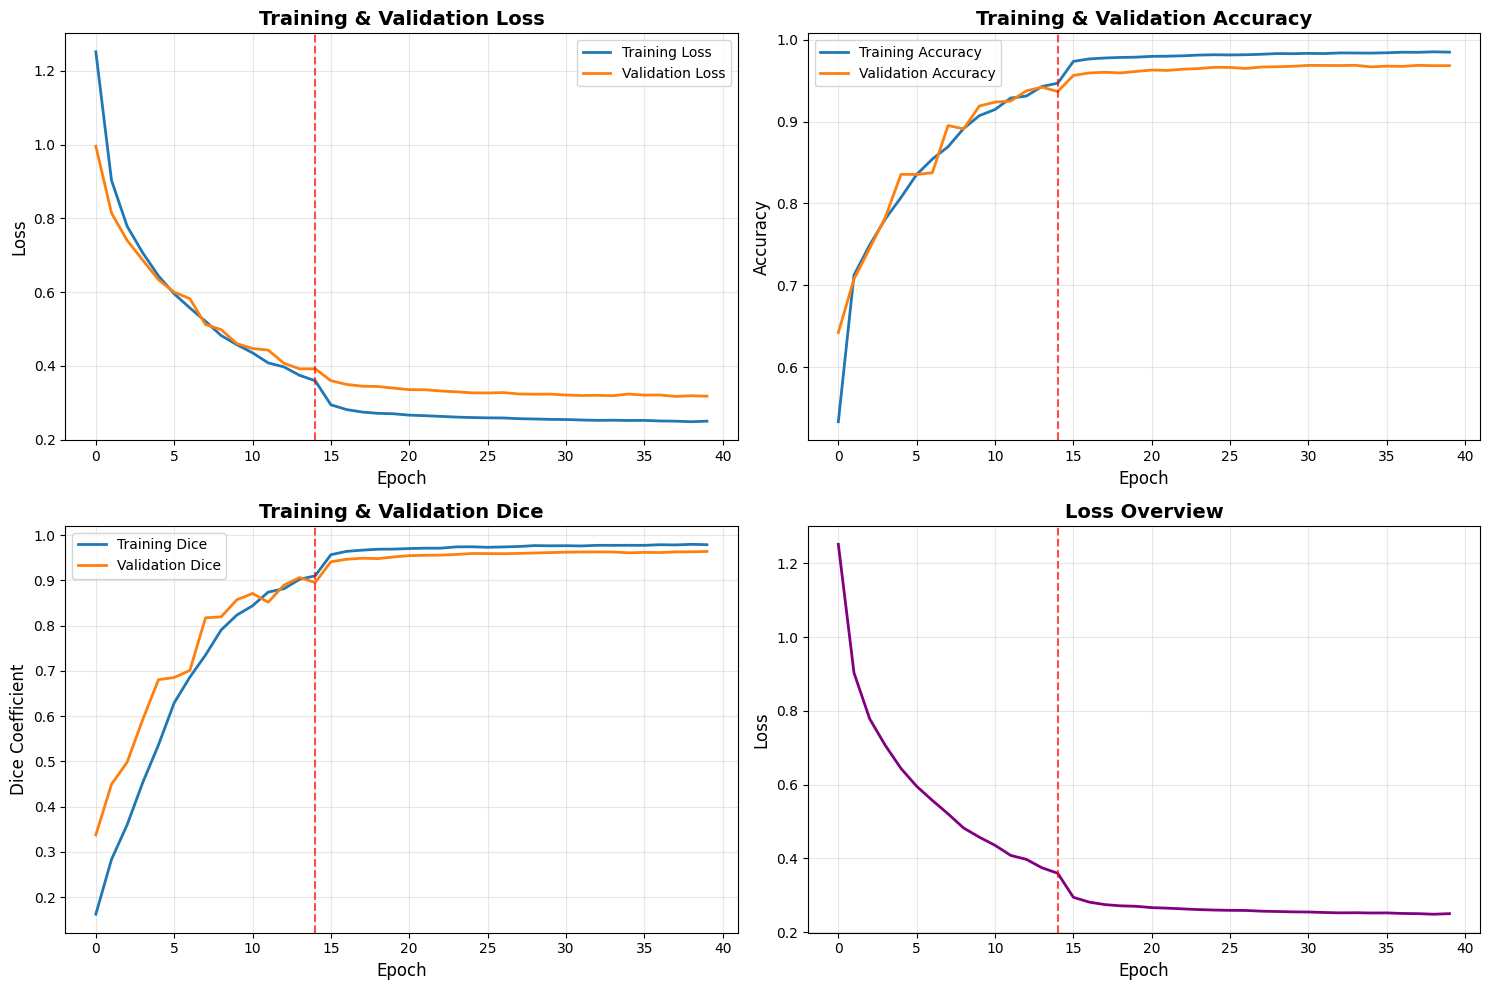


📈 Step 3: Evaluating Model...

📈 Evaluating Model Performance

✅ Found 150 validation images


Evaluating: 100%|██████████| 150/150 [00:20<00:00,  7.35it/s]



📊 Evaluation Results:
  Mean IoU:              0.9453 (94.53%)
  Mean Dice Coefficient: 0.9741 (97.41%)
  Mean Pixel Accuracy:   0.9715 (97.15%)

⏱️ Evaluation Time: 20.71 seconds (150 images)
⏱️ Average Time per Image: 0.14 seconds

💾 Evaluation results saved to: multiclass_segmentation_outputs/evaluation_results.json

🧪 Step 4: Testing on Sample Images...

🧪 Testing on Validation Set

📊 Testing on 5 validation images...


Image 1/5: 65.jpg
🍎 Y_Actual (True Fruit): Mango_Amrapali
🔮 Predicting with TTA (Original + H-Flip + V-Flip)...
⏱️ Inference Time: 5876.06 ms

🍎 Detected Fruits: Mango_Amrapali

📊 Confidence Report:
------------------------------------------------------------
Fruit Name                | Mean Probability   | Max Probability
------------------------------------------------------------
Mango_Amrapali            | 84.33%            | 98.85%
------------------------------------------------------------
💾 Visualization saved to: multiclass_segmentation_outputs/plots/predi

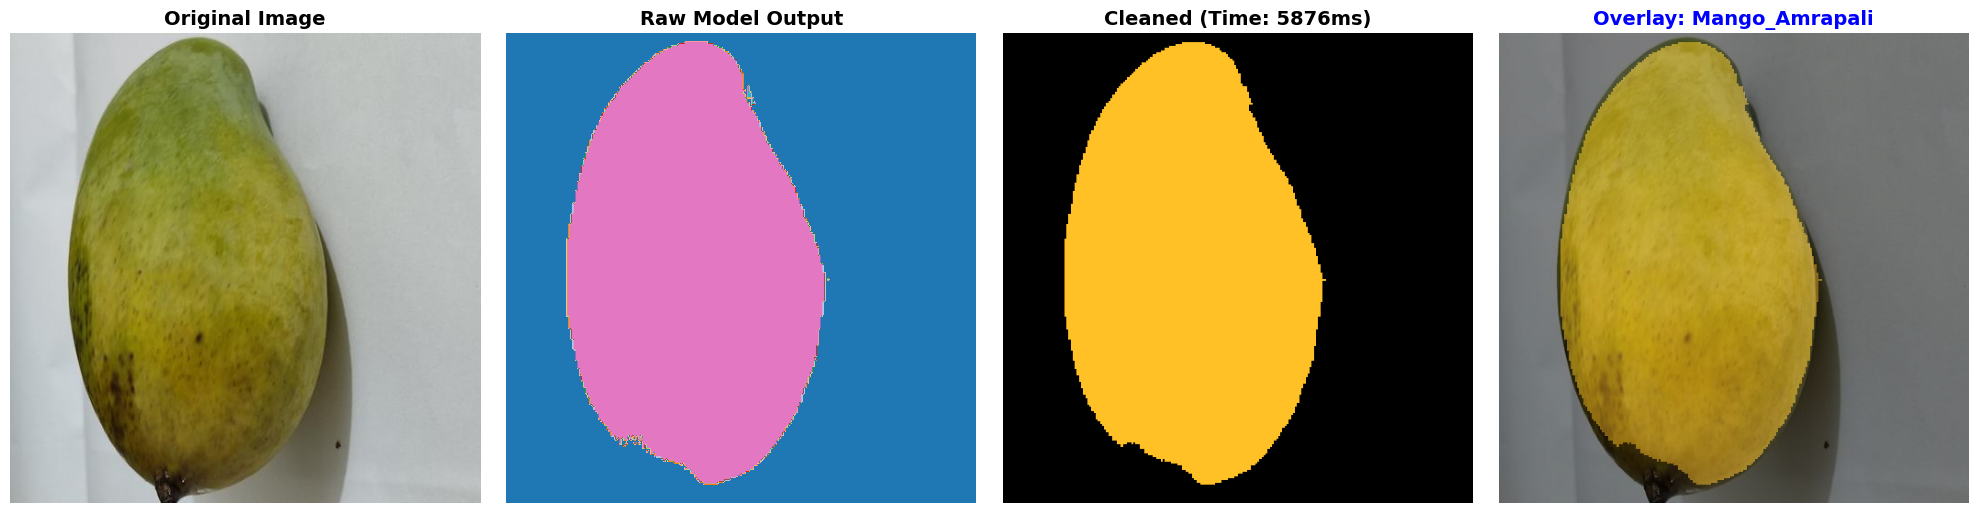


🎨 Color Legend:
--------------------------------------------------
  Mango_Amrapali: RGB(255, 193, 37)
--------------------------------------------------


Image 2/5: 53.jpg
🍎 Y_Actual (True Fruit): Apple_Golden Delicious
🔮 Predicting with TTA (Original + H-Flip + V-Flip)...
⏱️ Inference Time: 97.68 ms

🍎 Detected Fruits: Apple_Golden Delicious

📊 Confidence Report:
------------------------------------------------------------
Fruit Name                | Mean Probability   | Max Probability
------------------------------------------------------------
Apple_Golden Delicious    | 45.82%            | 91.50%
------------------------------------------------------------
💾 Visualization saved to: multiclass_segmentation_outputs/plots/prediction_53.jpg


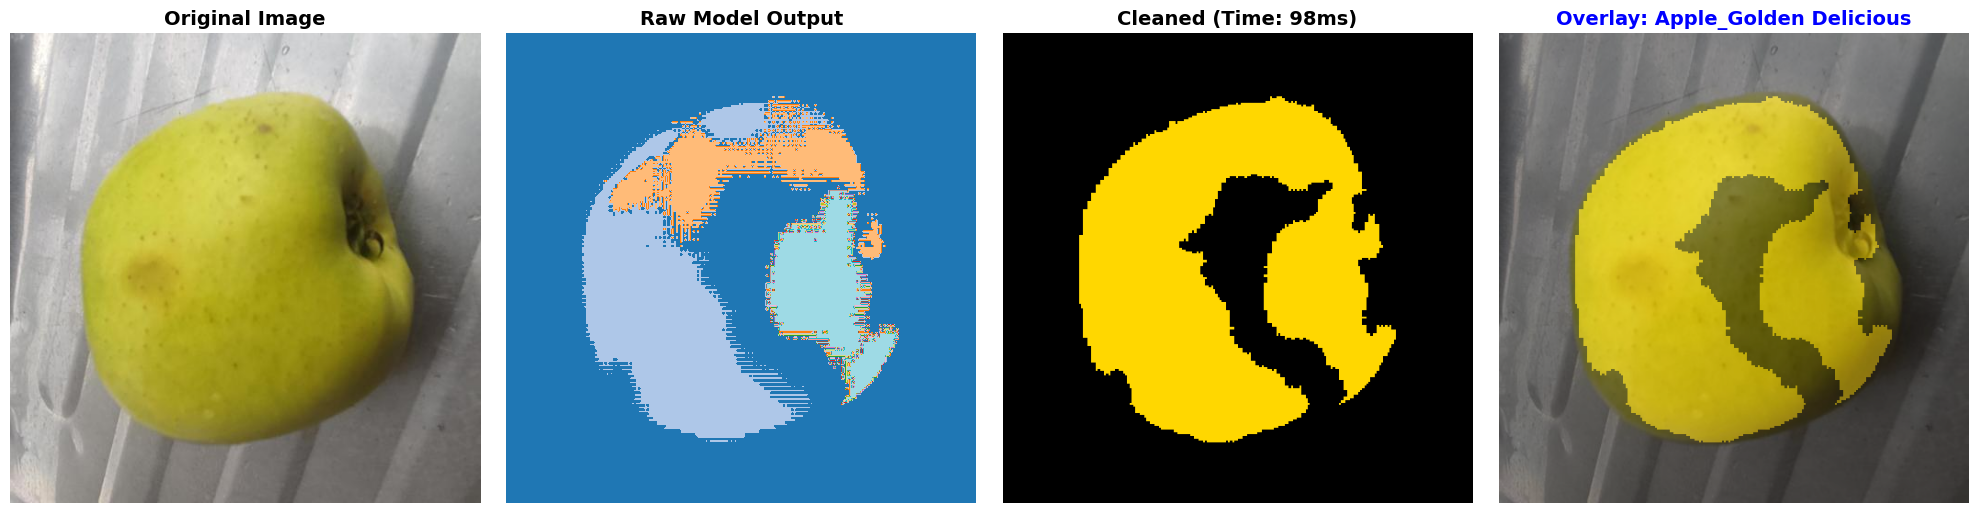


🎨 Color Legend:
--------------------------------------------------
  Apple_Golden Delicious: RGB(255, 215, 0)
--------------------------------------------------


Image 3/5: 55.jpg
🍎 Y_Actual (True Fruit): Mango_Bari
🔮 Predicting with TTA (Original + H-Flip + V-Flip)...
⏱️ Inference Time: 94.51 ms

🍎 Detected Fruits: Mango_Bari

📊 Confidence Report:
------------------------------------------------------------
Fruit Name                | Mean Probability   | Max Probability
------------------------------------------------------------
Mango_Bari                | 97.36%            | 99.69%
------------------------------------------------------------
💾 Visualization saved to: multiclass_segmentation_outputs/plots/prediction_55.jpg


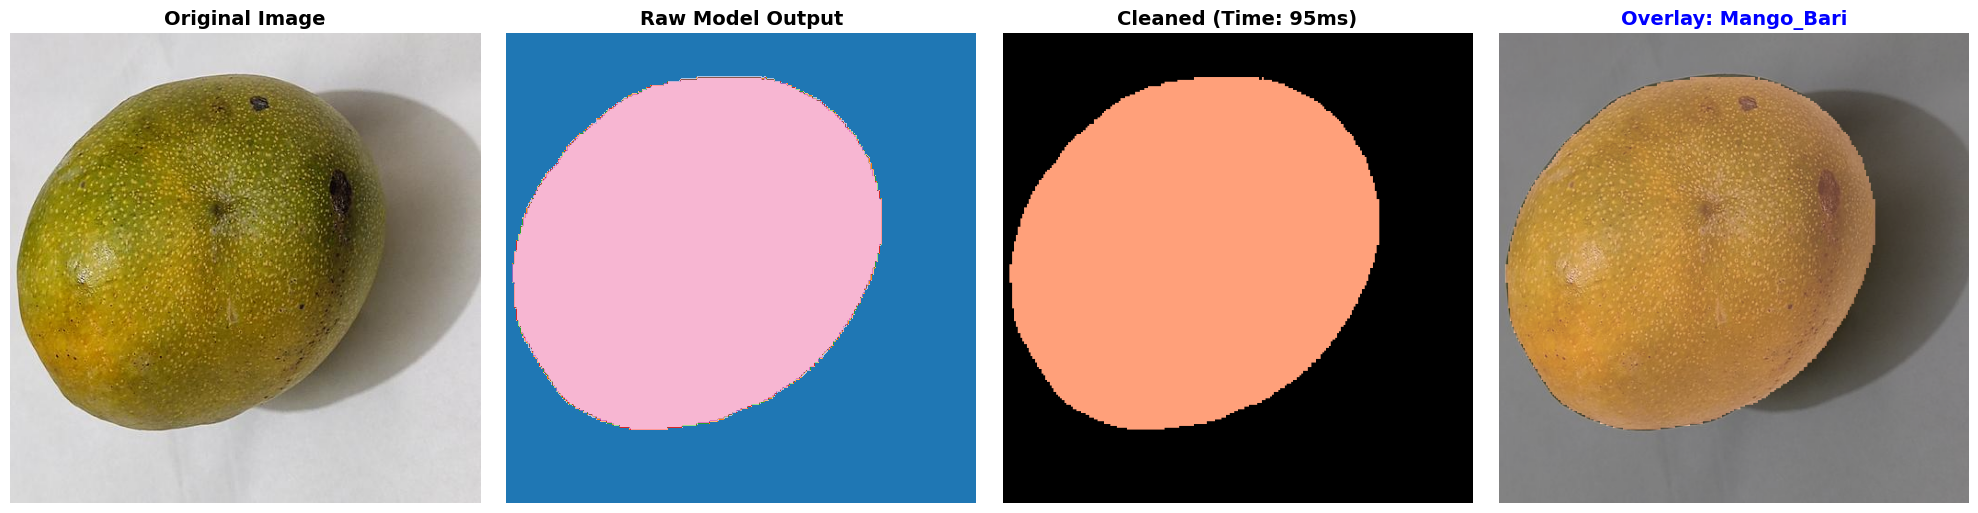


🎨 Color Legend:
--------------------------------------------------
  Mango_Bari: RGB(255, 160, 122)
--------------------------------------------------


Image 4/5: 61.jpg
🍎 Y_Actual (True Fruit): Pineapple
🔮 Predicting with TTA (Original + H-Flip + V-Flip)...
⏱️ Inference Time: 94.09 ms

🍎 Detected Fruits: Pineapple

📊 Confidence Report:
------------------------------------------------------------
Fruit Name                | Mean Probability   | Max Probability
------------------------------------------------------------
Pineapple                 | 88.99%            | 99.98%
------------------------------------------------------------
💾 Visualization saved to: multiclass_segmentation_outputs/plots/prediction_61.jpg


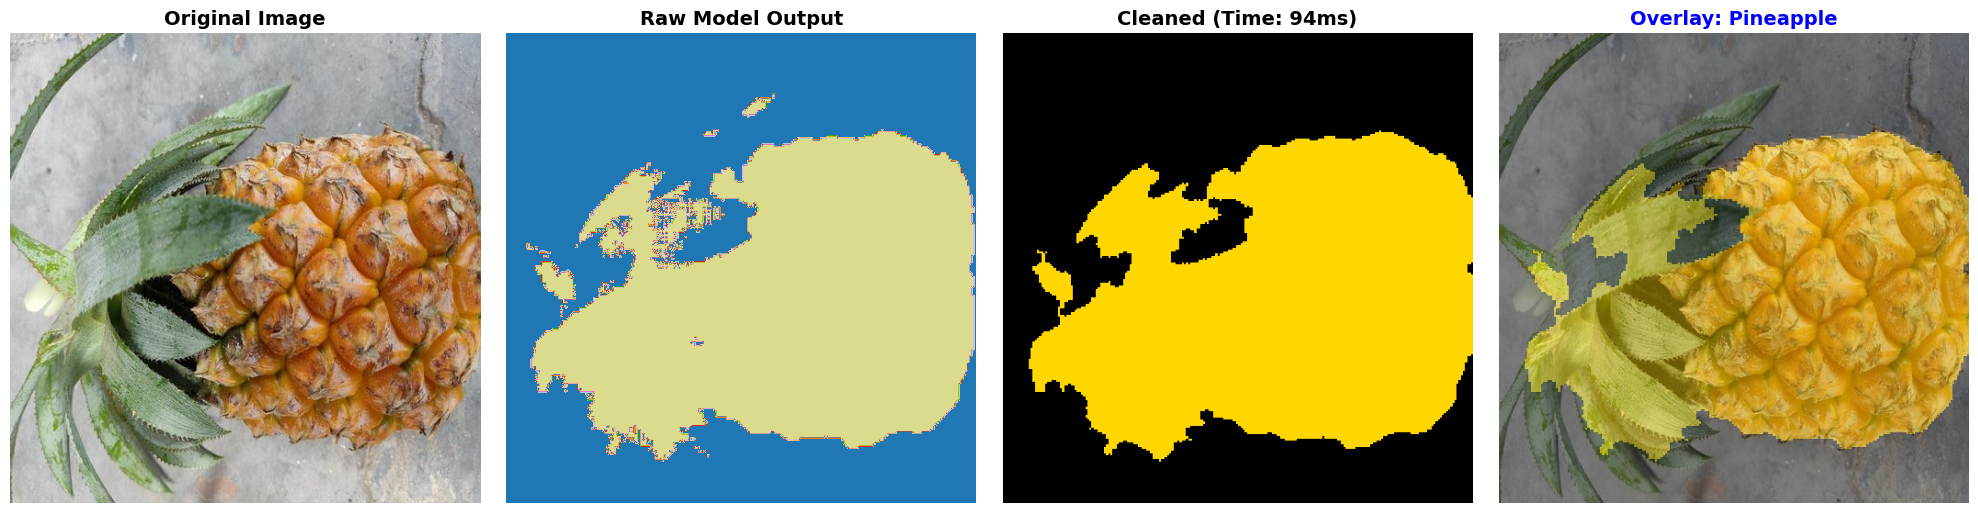


🎨 Color Legend:
--------------------------------------------------
  Pineapple: RGB(255, 215, 0)
--------------------------------------------------


Image 5/5: 85.jpg
🍎 Y_Actual (True Fruit): Hog Plum
🔮 Predicting with TTA (Original + H-Flip + V-Flip)...
⏱️ Inference Time: 92.43 ms

🍎 Detected Fruits: Hog Plum

📊 Confidence Report:
------------------------------------------------------------
Fruit Name                | Mean Probability   | Max Probability
------------------------------------------------------------
Hog Plum                  | 99.10%            | 100.00%
------------------------------------------------------------
💾 Visualization saved to: multiclass_segmentation_outputs/plots/prediction_85.jpg


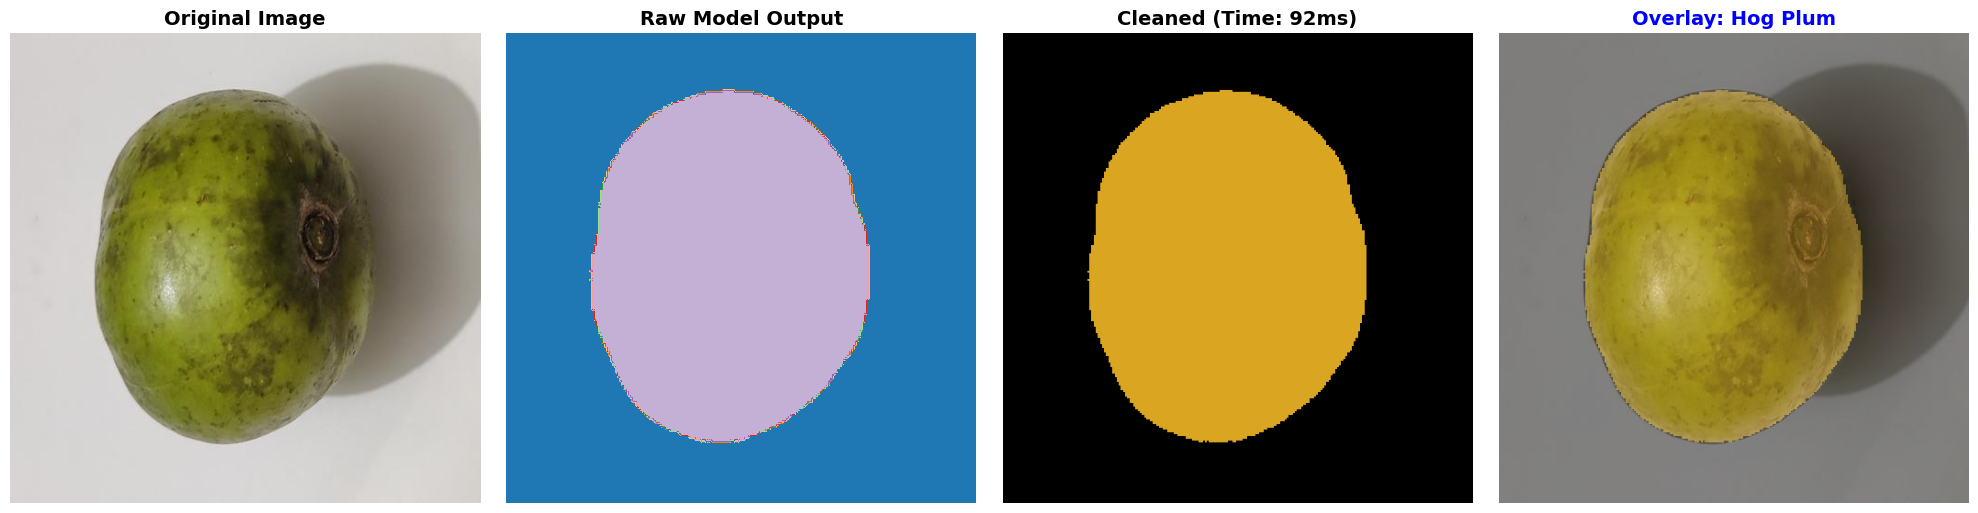


🎨 Color Legend:
--------------------------------------------------
  Hog Plum: RGB(218, 165, 32)
--------------------------------------------------


⏱️ TESTING TIME SUMMARY:
  Total Testing Time:         11.82 seconds
  Number of Images:           5
  Average Inference Time:     2361.23 ms/image
  Min Inference Time:         1145.67 ms
  Max Inference Time:         6982.32 ms

💾 Testing times saved to: multiclass_segmentation_outputs/testing_times.json

⏱️ Step 5: Creating Time Analysis Visualizations...

📊 Creating Time Analysis Visualizations


/tmp/ipykernel_47/1616970182.py:476: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_47/1616970182.py:478: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from current font.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_47/1616970182.py:478: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_47/1616970182.py:478: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_47/1616970182.py:478: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from current font.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_47/1616970182.py:478: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')



💾 Time analysis visualization saved to: multiclass_segmentation_outputs/plots/time_analysis_comprehensive.png


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


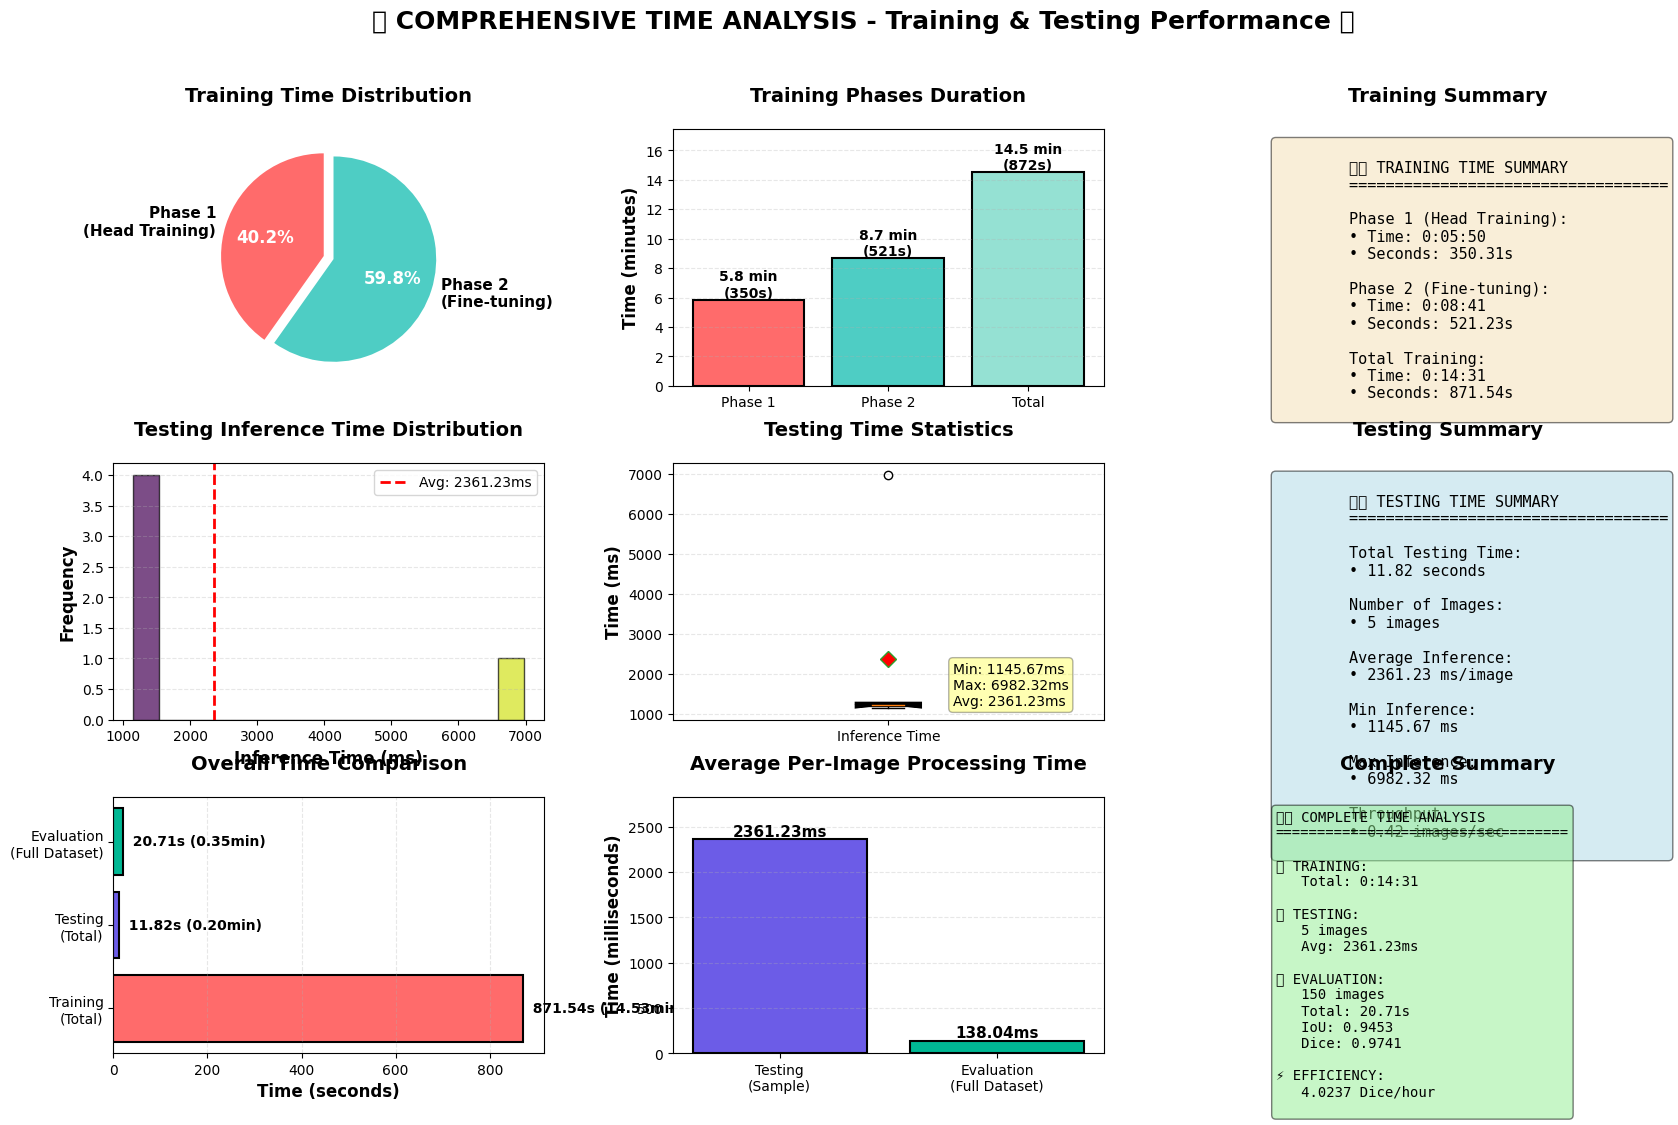


✅ Time analysis visualization complete!

🖼️ Step 6: Testing on External Image...
⚠️ External test image not found: /kaggle/input/test-kaggle/fruit/fruit.jpeg
💡 You can test with validation images instead.

🎉 ALL TASKS COMPLETED SUCCESSFULLY!

📂 Outputs saved in: multiclass_segmentation_outputs
   - Models: multiclass_segmentation_outputs/models
   - Plots: multiclass_segmentation_outputs/plots
   - Logs: multiclass_segmentation_outputs/logs

💡 To test new images, use:
   predict_and_visualize('path/to/image.jpg', model, class_mapping, color_mapping)

📊 To regenerate time analysis:
   plot_time_analysis()

✨ Happy Fruit Segmentation! 🍎🍌🍊🍇



In [ ]:
if __name__ == "__main__":
    print("\n🎯 Starting Advanced Fruit Segmentation System\n")


    print("\n📊 Step 2: Plotting Training History...")
    plot_training_history()


    print("\n📈 Step 3: Evaluating Model...")
    evaluate_model(model, class_mapping)


    print("\n🧪 Step 4: Testing on Sample Images...")
    test_on_validation_set(model, class_mapping, color_mapping, num_samples=5)


    print("\n⏱️ Step 5: Creating Time Analysis Visualizations...")
    plot_time_analysis()


    print("\n🖼️ Step 6: Testing on External Image...")
    external_image_path = '/kaggle/input/test-kaggle/fruit/fruit.jpeg'

    if os.path.exists(external_image_path):
        predict_and_visualize(external_image_path, model, class_mapping, color_mapping)
    else:
        print(f"⚠️ External test image not found: {external_image_path}")
        print(" You can test with validation images instead.")

    print("\n" + "="*80)
    print("🎉 ALL TASKS COMPLETED SUCCESSFULLY!")
    print("="*80)
    print("\n Outputs saved in:", MultiClassConfig.OUTPUT_DIR)
    print(f"   - Models: {MultiClassConfig.MODEL_DIR}")
    print(f"   - Plots: {MultiClassConfig.PLOTS_DIR}")
    print(f"   - Logs: {MultiClassConfig.LOGS_DIR}")
    print("\n To test new images, use:")
    print("   predict_and_visualize('path/to/image.jpg', model, class_mapping, color_mapping)")
    print("\n To regenerate time analysis:")
    print("   plot_time_analysis()")
    print("\n Happy Fruit Segmentation! \n")